In [10]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

import copy


In [2]:
import sys

print(sys.version)
print(sys.version_info)

3.10.10 (v3.10.10:aad5f6a891, Feb  7 2023, 08:47:40) [Clang 13.0.0 (clang-1300.0.29.30)]
sys.version_info(major=3, minor=10, micro=10, releaselevel='final', serial=0)


In [3]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

train_file = np.load("./cse-251-b-2025/train.npz")
train_data = train_file['data']
print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)

test_file = np.load("./cse-251-b-2025/test_input.npz")
test_data = test_file['data']
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

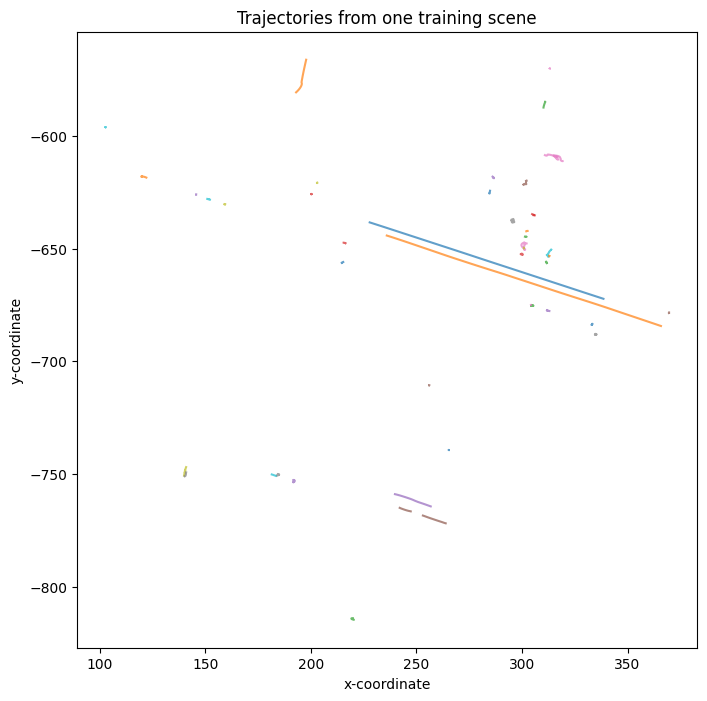

In [4]:
# Plot trajectories from one training scene (static plot)
data_matrix = train_data[0]

plt.figure(figsize=(8, 8))
for agent in range(data_matrix.shape[0]):
    xs = data_matrix[agent, :, 0]
    ys = data_matrix[agent, :, 1]
    # Remove zeros (padding)
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    plt.plot(xs, ys, alpha=0.7)
plt.title("Trajectories from one training scene")
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.show()

# Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = None
    if sys.version_info.minor <= 7:
        cmap = plt.cm.get_cmap("viridis", 50)
    else:
        cmap = plt.get_cmap("viridis", 50)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

data_matrix = train_data[0]        
make_gif(data_matrix, 'index0')

# Baseline 1: Constant Velocity Model for Test Set:

In [5]:
# Run this?
run_constant_velocity_model = False

if run_constant_velocity_model:
    # Compute the velocity differences for the ego vehicle (agent index 0)
    velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
    print("Velocity difference shape:", velocity_diff.shape)

    # Compute average velocity for the ego vehicle (index 0) in each scene
    constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
    print("Constant velocity shape:", constant_vel.shape)

    # Generate predictions for 60 future time steps based on constant velocity
    pred_y_const = np.zeros((test_data.shape[0], 60, 2))
    starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

    for t in range(60):
        pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

    # Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
    pred_output_const = pred_y_const.reshape(-1, 2)
    output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
    output_df_const.index.name = 'index'
    # Save output in the submission folder
    constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
    output_df_const.to_csv(constant_vel_path)
    print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

# Baseline 2: MLP Model using PyTorch:

In [6]:
# Prepare training data: use first 50 time steps as input and last 60 time steps of the ego vehicle as output
train_x = train_data[..., :50, :]  # Shape: (10000, 50, 50, 6)
train_y = train_data[:, 0, 50:, :2]  # Shape: (10000, 60, 2)
print("Train x shape:", train_x.shape, "Train y shape:", train_y.shape)

Train x shape: (10000, 50, 50, 6) Train y shape: (10000, 60, 2)


In [7]:
# Baseline MLP model using Pytorch, untouched from the original notebook

# Define the MLP model architecture
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, output_features),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.mlp(x)
        return x
    

# Our Work

In [ ]:
# Select GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Multi agent scene context model
class SceneContextModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.agent_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.ego_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 60 * 2)
        )

    def forward(self, x_flat):
        B = x_flat.size(0)
        x = x_flat.view(B, 50, 50, 6) #(B, agents, timesteps, features)
        x_agents = x.view(B, 50, -1)  #(B, 50, 300)
        agent_feats = self.agent_encoder(x_agents) #(B, 50, hidden_dim)
        scene_context = agent_feats.mean(dim=1) #(B, hidden_dim)

        ego_input = x[:, 0, :, :].reshape(B, -1) #(B, 300)
        ego_feat = self.ego_encoder(ego_input) #(B, hidden_dim)

        combined = torch.cat([ego_feat, scene_context], dim=1)
        return self.decoder(combined) #(B, 120)



Using device: cpu


# Training loop

Change which model is used at the `model = ...(input_features, output_features)` line.

Change which optimizer is used at the `optimizer = optim...` line.

Do **NOT** change the `criterion`, as MSE is stated in the Data tab of the competition.

In [12]:
#flat dimensions
input_features = 50 * 50 * 6  #full input flattened
output_features = 60 * 2  #60 future time steps × 2D


#Initialize model, loss, optimizer, scheduler
OurModel = SceneContextModel(hidden_dim=864).to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(OurModel.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10, # epochs to first restart
    T_mult=2, # factor to increase T_i after each restart
    eta_min=1e-6 # lower bound on LR
)

#Training loop
def train_model(model, x_train, y_train, batch_size=32, epochs=100):
    X_train_tensor = torch.FloatTensor(x_train).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(y_train).reshape((-1, output_features))
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    best_loss = float('inf')
    best_model_state = None
    
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        
        for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Step the scheduler after each epoch
        current_lr = optimizer.param_groups[0]['lr']
        if(best_loss > 37):
            scheduler.step()
        else:
            optimizer.param_groups[0]['lr'] = 1e-6
        new_lr = optimizer.param_groups[0]['lr']
        
        epoch_loss = running_loss/len(train_loader)
        print(f'Epoch {epoch+1} Loss: {epoch_loss:.4f}, LR: {current_lr:.2e} → {new_lr:.2e}')
        
        # Save best model
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_state = copy.deepcopy(model.state_dict())
    
    #Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f'Best Loss: {best_loss:.4f}')
    return model

#Train and reassign to OurModel
OurModel = train_model(OurModel, train_x, train_y, batch_size=4, epochs=100)

#Prediction helper
def predict(model, X_test):
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features)).to(device)
        predictions = model(X_test_tensor).cpu().reshape((-1, 60, 2))
    return predictions.numpy()


#Generate test predictions 
model_predictions = predict(OurModel, test_data) #test_data shape (2100, 50, 50, 6)

#Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
pred_output = model_predictions.reshape(-1, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'

#Save output in the submission folder, timestamped!
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%I-%M%p")

submission_path = os.path.join(submission_dir, f"submission-{timestamp}.csv")
output_df.to_csv(submission_path)
print(f"Submission saved locally as: '{submission_path}'.")

Epoch 1: 100%|██████████| 2500/2500 [00:18<00:00, 134.97it/s]


Epoch 1 Loss: 117733.8153, LR: 1.00e-04 → 9.76e-05


Epoch 2: 100%|██████████| 2500/2500 [00:19<00:00, 126.46it/s]


Epoch 2 Loss: 10121.0465, LR: 9.76e-05 → 9.05e-05


Epoch 3: 100%|██████████| 2500/2500 [00:19<00:00, 131.09it/s]


Epoch 3 Loss: 5700.3978, LR: 9.05e-05 → 7.96e-05


Epoch 4: 100%|██████████| 2500/2500 [00:18<00:00, 134.26it/s]


Epoch 4 Loss: 4215.6560, LR: 7.96e-05 → 6.58e-05


Epoch 5: 100%|██████████| 2500/2500 [00:19<00:00, 129.15it/s]


Epoch 5 Loss: 3266.4501, LR: 6.58e-05 → 5.05e-05


Epoch 6: 100%|██████████| 2500/2500 [00:18<00:00, 138.71it/s]


Epoch 6 Loss: 1628.5933, LR: 5.05e-05 → 3.52e-05


Epoch 7: 100%|██████████| 2500/2500 [00:18<00:00, 132.08it/s]


Epoch 7 Loss: 835.7390, LR: 3.52e-05 → 2.14e-05


Epoch 8: 100%|██████████| 2500/2500 [00:18<00:00, 134.29it/s]


Epoch 8 Loss: 327.7737, LR: 2.14e-05 → 1.05e-05


Epoch 9: 100%|██████████| 2500/2500 [00:19<00:00, 130.13it/s]


Epoch 9 Loss: 127.5823, LR: 1.05e-05 → 3.42e-06


Epoch 10: 100%|██████████| 2500/2500 [00:19<00:00, 125.40it/s]


Epoch 10 Loss: 74.9389, LR: 3.42e-06 → 1.00e-04


Epoch 11: 100%|██████████| 2500/2500 [00:19<00:00, 129.02it/s]


Epoch 11 Loss: 11695.3964, LR: 1.00e-04 → 9.94e-05


Epoch 12: 100%|██████████| 2500/2500 [00:17<00:00, 145.35it/s]


Epoch 12 Loss: 3252.5524, LR: 9.94e-05 → 9.76e-05


Epoch 13: 100%|██████████| 2500/2500 [00:17<00:00, 144.23it/s]


Epoch 13 Loss: 7139.9835, LR: 9.76e-05 → 9.46e-05


Epoch 14: 100%|██████████| 2500/2500 [00:18<00:00, 135.33it/s]


Epoch 14 Loss: 2552.8903, LR: 9.46e-05 → 9.05e-05


Epoch 15: 100%|██████████| 2500/2500 [00:17<00:00, 140.35it/s]


Epoch 15 Loss: 3239.4254, LR: 9.05e-05 → 8.55e-05


Epoch 16: 100%|██████████| 2500/2500 [00:18<00:00, 132.88it/s]


Epoch 16 Loss: 3235.2528, LR: 8.55e-05 → 7.96e-05


Epoch 17: 100%|██████████| 2500/2500 [00:18<00:00, 134.94it/s]


Epoch 17 Loss: 2024.3480, LR: 7.96e-05 → 7.30e-05


Epoch 18: 100%|██████████| 2500/2500 [00:19<00:00, 125.96it/s]


Epoch 18 Loss: 2037.1545, LR: 7.30e-05 → 6.58e-05


Epoch 19: 100%|██████████| 2500/2500 [00:18<00:00, 131.76it/s]


Epoch 19 Loss: 1625.0354, LR: 6.58e-05 → 5.82e-05


Epoch 20: 100%|██████████| 2500/2500 [00:18<00:00, 132.49it/s]


Epoch 20 Loss: 1266.9088, LR: 5.82e-05 → 5.05e-05


Epoch 21: 100%|██████████| 2500/2500 [00:19<00:00, 128.56it/s]


Epoch 21 Loss: 1013.5219, LR: 5.05e-05 → 4.28e-05


Epoch 22: 100%|██████████| 2500/2500 [00:18<00:00, 133.53it/s]


Epoch 22 Loss: 474.1553, LR: 4.28e-05 → 3.52e-05


Epoch 23: 100%|██████████| 2500/2500 [00:19<00:00, 127.01it/s]


Epoch 23 Loss: 432.4784, LR: 3.52e-05 → 2.80e-05


Epoch 24: 100%|██████████| 2500/2500 [00:18<00:00, 135.26it/s]


Epoch 24 Loss: 329.3310, LR: 2.80e-05 → 2.14e-05


Epoch 25: 100%|██████████| 2500/2500 [00:18<00:00, 133.24it/s]


Epoch 25 Loss: 134.1992, LR: 2.14e-05 → 1.55e-05


Epoch 26: 100%|██████████| 2500/2500 [00:18<00:00, 135.82it/s]


Epoch 26 Loss: 99.0430, LR: 1.55e-05 → 1.05e-05


Epoch 27: 100%|██████████| 2500/2500 [00:18<00:00, 133.51it/s]


Epoch 27 Loss: 75.3986, LR: 1.05e-05 → 6.40e-06


Epoch 28: 100%|██████████| 2500/2500 [00:18<00:00, 133.33it/s]


Epoch 28 Loss: 55.9533, LR: 6.40e-06 → 3.42e-06


Epoch 29: 100%|██████████| 2500/2500 [00:20<00:00, 124.66it/s]


Epoch 29 Loss: 44.2662, LR: 3.42e-06 → 1.61e-06


Epoch 30: 100%|██████████| 2500/2500 [00:18<00:00, 135.29it/s]


Epoch 30 Loss: 39.5651, LR: 1.61e-06 → 1.00e-04


Epoch 31: 100%|██████████| 2500/2500 [00:19<00:00, 126.91it/s]


Epoch 31 Loss: 6202.4986, LR: 1.00e-04 → 9.98e-05


Epoch 32: 100%|██████████| 2500/2500 [00:18<00:00, 133.65it/s]


Epoch 32 Loss: 2419.1567, LR: 9.98e-05 → 9.94e-05


Epoch 33: 100%|██████████| 2500/2500 [00:19<00:00, 131.40it/s]


Epoch 33 Loss: 2888.9174, LR: 9.94e-05 → 9.86e-05


Epoch 34: 100%|██████████| 2500/2500 [00:19<00:00, 130.29it/s]


Epoch 34 Loss: 2536.9822, LR: 9.86e-05 → 9.76e-05


Epoch 35: 100%|██████████| 2500/2500 [00:18<00:00, 131.97it/s]


Epoch 35 Loss: 3721.0532, LR: 9.76e-05 → 9.62e-05


Epoch 36: 100%|██████████| 2500/2500 [00:19<00:00, 130.10it/s]


Epoch 36 Loss: 1243.3010, LR: 9.62e-05 → 9.46e-05


Epoch 37: 100%|██████████| 2500/2500 [00:18<00:00, 133.06it/s]


Epoch 37 Loss: 1858.4943, LR: 9.46e-05 → 9.27e-05


Epoch 38: 100%|██████████| 2500/2500 [00:19<00:00, 127.34it/s]


Epoch 38 Loss: 1955.7793, LR: 9.27e-05 → 9.05e-05


Epoch 39: 100%|██████████| 2500/2500 [00:17<00:00, 139.75it/s]


Epoch 39 Loss: 1553.4439, LR: 9.05e-05 → 8.81e-05


Epoch 40: 100%|██████████| 2500/2500 [00:17<00:00, 143.46it/s]


Epoch 40 Loss: 1321.5799, LR: 8.81e-05 → 8.55e-05


Epoch 41: 100%|██████████| 2500/2500 [00:18<00:00, 134.49it/s]


Epoch 41 Loss: 1302.7161, LR: 8.55e-05 → 8.26e-05


Epoch 42: 100%|██████████| 2500/2500 [00:18<00:00, 135.11it/s]


Epoch 42 Loss: 1188.7555, LR: 8.26e-05 → 7.96e-05


Epoch 43: 100%|██████████| 2500/2500 [00:20<00:00, 123.72it/s]


Epoch 43 Loss: 1388.5036, LR: 7.96e-05 → 7.64e-05


Epoch 44: 100%|██████████| 2500/2500 [00:17<00:00, 139.74it/s]


Epoch 44 Loss: 952.2738, LR: 7.64e-05 → 7.30e-05


Epoch 45: 100%|██████████| 2500/2500 [00:17<00:00, 140.86it/s]


Epoch 45 Loss: 1067.1654, LR: 7.30e-05 → 6.94e-05


Epoch 46: 100%|██████████| 2500/2500 [00:17<00:00, 142.43it/s]


Epoch 46 Loss: 865.7576, LR: 6.94e-05 → 6.58e-05


Epoch 47: 100%|██████████| 2500/2500 [00:17<00:00, 142.77it/s]


Epoch 47 Loss: 766.5497, LR: 6.58e-05 → 6.21e-05


Epoch 48: 100%|██████████| 2500/2500 [00:17<00:00, 143.06it/s]


Epoch 48 Loss: 565.3662, LR: 6.21e-05 → 5.82e-05


Epoch 49: 100%|██████████| 2500/2500 [00:17<00:00, 140.74it/s]


Epoch 49 Loss: 541.7971, LR: 5.82e-05 → 5.44e-05


Epoch 50: 100%|██████████| 2500/2500 [00:17<00:00, 144.02it/s]


Epoch 50 Loss: 639.7688, LR: 5.44e-05 → 5.05e-05


Epoch 51: 100%|██████████| 2500/2500 [00:17<00:00, 142.44it/s]


Epoch 51 Loss: 411.3534, LR: 5.05e-05 → 4.66e-05


Epoch 52: 100%|██████████| 2500/2500 [00:17<00:00, 145.28it/s]


Epoch 52 Loss: 285.8707, LR: 4.66e-05 → 4.28e-05


Epoch 53: 100%|██████████| 2500/2500 [00:17<00:00, 140.99it/s]


Epoch 53 Loss: 374.8152, LR: 4.28e-05 → 3.89e-05


Epoch 54: 100%|██████████| 2500/2500 [00:17<00:00, 144.52it/s]


Epoch 54 Loss: 246.5062, LR: 3.89e-05 → 3.52e-05


Epoch 55: 100%|██████████| 2500/2500 [00:18<00:00, 138.76it/s]


Epoch 55 Loss: 234.5498, LR: 3.52e-05 → 3.16e-05


Epoch 56: 100%|██████████| 2500/2500 [00:17<00:00, 144.89it/s]


Epoch 56 Loss: 134.2393, LR: 3.16e-05 → 2.80e-05


Epoch 57: 100%|██████████| 2500/2500 [00:17<00:00, 142.75it/s]


Epoch 57 Loss: 180.3759, LR: 2.80e-05 → 2.46e-05


Epoch 58: 100%|██████████| 2500/2500 [00:17<00:00, 144.19it/s]


Epoch 58 Loss: 103.7394, LR: 2.46e-05 → 2.14e-05


Epoch 59: 100%|██████████| 2500/2500 [00:17<00:00, 143.78it/s]


Epoch 59 Loss: 97.6010, LR: 2.14e-05 → 1.84e-05


Epoch 60: 100%|██████████| 2500/2500 [00:17<00:00, 138.92it/s]


Epoch 60 Loss: 84.4279, LR: 1.84e-05 → 1.55e-05


Epoch 61: 100%|██████████| 2500/2500 [00:18<00:00, 134.82it/s]


Epoch 61 Loss: 75.0770, LR: 1.55e-05 → 1.29e-05


Epoch 62: 100%|██████████| 2500/2500 [00:17<00:00, 139.72it/s]


Epoch 62 Loss: 58.7967, LR: 1.29e-05 → 1.05e-05


Epoch 63: 100%|██████████| 2500/2500 [00:17<00:00, 140.14it/s]


Epoch 63 Loss: 48.3784, LR: 1.05e-05 → 8.29e-06


Epoch 64: 100%|██████████| 2500/2500 [00:17<00:00, 139.81it/s]


Epoch 64 Loss: 44.3808, LR: 8.29e-06 → 6.40e-06


Epoch 65: 100%|██████████| 2500/2500 [00:18<00:00, 138.66it/s]


Epoch 65 Loss: 36.4911, LR: 6.40e-06 → 4.77e-06


Epoch 66: 100%|██████████| 2500/2500 [00:19<00:00, 126.07it/s]


Epoch 66 Loss: 33.3908, LR: 4.77e-06 → 1.00e-06


Epoch 67: 100%|██████████| 2500/2500 [00:20<00:00, 124.86it/s]


Epoch 67 Loss: 26.3294, LR: 1.00e-06 → 1.00e-06


Epoch 68: 100%|██████████| 2500/2500 [00:20<00:00, 120.36it/s]


Epoch 68 Loss: 26.3423, LR: 1.00e-06 → 1.00e-06


Epoch 69: 100%|██████████| 2500/2500 [00:18<00:00, 133.92it/s]


Epoch 69 Loss: 26.2250, LR: 1.00e-06 → 1.00e-06


Epoch 70: 100%|██████████| 2500/2500 [00:17<00:00, 139.39it/s]


Epoch 70 Loss: 26.1001, LR: 1.00e-06 → 1.00e-06


Epoch 71: 100%|██████████| 2500/2500 [00:19<00:00, 127.82it/s]


Epoch 71 Loss: 26.0731, LR: 1.00e-06 → 1.00e-06


Epoch 72: 100%|██████████| 2500/2500 [00:18<00:00, 136.60it/s]


Epoch 72 Loss: 25.9919, LR: 1.00e-06 → 1.00e-06


Epoch 73: 100%|██████████| 2500/2500 [00:19<00:00, 128.41it/s]


Epoch 73 Loss: 25.9672, LR: 1.00e-06 → 1.00e-06


Epoch 74: 100%|██████████| 2500/2500 [00:20<00:00, 124.31it/s]


Epoch 74 Loss: 25.8398, LR: 1.00e-06 → 1.00e-06


Epoch 75: 100%|██████████| 2500/2500 [00:18<00:00, 134.44it/s]


Epoch 75 Loss: 25.8457, LR: 1.00e-06 → 1.00e-06


Epoch 76: 100%|██████████| 2500/2500 [00:20<00:00, 123.67it/s]


Epoch 76 Loss: 25.7257, LR: 1.00e-06 → 1.00e-06


Epoch 77: 100%|██████████| 2500/2500 [00:23<00:00, 108.11it/s]


Epoch 77 Loss: 25.6190, LR: 1.00e-06 → 1.00e-06


Epoch 78: 100%|██████████| 2500/2500 [00:22<00:00, 112.38it/s]


Epoch 78 Loss: 25.6625, LR: 1.00e-06 → 1.00e-06


Epoch 79: 100%|██████████| 2500/2500 [00:22<00:00, 112.08it/s]


Epoch 79 Loss: 25.3881, LR: 1.00e-06 → 1.00e-06


Epoch 80: 100%|██████████| 2500/2500 [00:26<00:00, 95.18it/s] 


Epoch 80 Loss: 25.5394, LR: 1.00e-06 → 1.00e-06


Epoch 81: 100%|██████████| 2500/2500 [00:26<00:00, 93.26it/s] 


Epoch 81 Loss: 25.3621, LR: 1.00e-06 → 1.00e-06


Epoch 82: 100%|██████████| 2500/2500 [00:24<00:00, 103.02it/s]


Epoch 82 Loss: 25.3107, LR: 1.00e-06 → 1.00e-06


Epoch 83: 100%|██████████| 2500/2500 [00:24<00:00, 103.38it/s]


Epoch 83 Loss: 25.2844, LR: 1.00e-06 → 1.00e-06


Epoch 84: 100%|██████████| 2500/2500 [00:23<00:00, 104.26it/s]


Epoch 84 Loss: 25.3333, LR: 1.00e-06 → 1.00e-06


Epoch 85: 100%|██████████| 2500/2500 [00:23<00:00, 105.35it/s]


Epoch 85 Loss: 25.1950, LR: 1.00e-06 → 1.00e-06


Epoch 86: 100%|██████████| 2500/2500 [00:23<00:00, 105.58it/s]


Epoch 86 Loss: 25.1899, LR: 1.00e-06 → 1.00e-06


Epoch 87: 100%|██████████| 2500/2500 [00:24<00:00, 102.11it/s]


Epoch 87 Loss: 25.0727, LR: 1.00e-06 → 1.00e-06


Epoch 88: 100%|██████████| 2500/2500 [00:26<00:00, 95.78it/s] 


Epoch 88 Loss: 24.9645, LR: 1.00e-06 → 1.00e-06


Epoch 89: 100%|██████████| 2500/2500 [00:27<00:00, 91.52it/s] 


Epoch 89 Loss: 25.0611, LR: 1.00e-06 → 1.00e-06


Epoch 90: 100%|██████████| 2500/2500 [00:27<00:00, 91.41it/s] 


Epoch 90 Loss: 24.9696, LR: 1.00e-06 → 1.00e-06


Epoch 91: 100%|██████████| 2500/2500 [00:26<00:00, 94.74it/s] 


Epoch 91 Loss: 24.8543, LR: 1.00e-06 → 1.00e-06


Epoch 92: 100%|██████████| 2500/2500 [00:27<00:00, 91.86it/s]


Epoch 92 Loss: 24.7639, LR: 1.00e-06 → 1.00e-06


Epoch 93: 100%|██████████| 2500/2500 [00:26<00:00, 92.60it/s] 


Epoch 93 Loss: 24.8137, LR: 1.00e-06 → 1.00e-06


Epoch 94: 100%|██████████| 2500/2500 [00:26<00:00, 95.25it/s] 


Epoch 94 Loss: 24.6959, LR: 1.00e-06 → 1.00e-06


Epoch 95: 100%|██████████| 2500/2500 [00:26<00:00, 94.62it/s] 


Epoch 95 Loss: 24.7784, LR: 1.00e-06 → 1.00e-06


Epoch 96: 100%|██████████| 2500/2500 [00:27<00:00, 91.01it/s] 


Epoch 96 Loss: 24.6312, LR: 1.00e-06 → 1.00e-06


Epoch 97: 100%|██████████| 2500/2500 [00:24<00:00, 102.53it/s]


Epoch 97 Loss: 24.6892, LR: 1.00e-06 → 1.00e-06


Epoch 98: 100%|██████████| 2500/2500 [00:23<00:00, 104.94it/s]


Epoch 98 Loss: 24.6092, LR: 1.00e-06 → 1.00e-06


Epoch 99: 100%|██████████| 2500/2500 [00:24<00:00, 103.29it/s]


Epoch 99 Loss: 24.5158, LR: 1.00e-06 → 1.00e-06


Epoch 100: 100%|██████████| 2500/2500 [00:24<00:00, 103.60it/s]


Epoch 100 Loss: 24.5262, LR: 1.00e-06 → 1.00e-06
Best Loss: 24.5158
Submission saved locally as: './submission/submission-2025-05-08_02-27PM.csv'.


In [ ]:
# Functions to save and load the model (should correspond to what was trained!)
# def save_model(model, path="our_model.pth"):
#     torch.save(model.state_dict(), path)
#     print(f"Model saved to {path}")


# def load_model(path="our_model.pth"):
#     loaded_model = OurModel(input_features, output_features)
#     loaded_model.load_state_dict(torch.load(path))
#     loaded_model.eval()
#     return loaded_model


# Example usage:
# save_model(model)
# model = load_model()